In [24]:
import pandas as pd
from datasets import load_dataset
import random
import sqlite3
from local_email_db import DEFAULT_DB_PATH

# Load the dataset from Hugging Face
dataset = load_dataset("corbt/enron_emails_sample_questions")

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset["train"])  # type: ignore

# Print basic dataset info
print(f"Dataset size: {len(df)} samples")
print(f"Columns: {df.columns.tolist()}")
print(f"Number of unique inboxes: {df['inbox_address'].nunique()}")
print(f"Average realism score: {df['how_realistic'].mean():.2f}")

# Connect to the SQLite database
conn = sqlite3.connect(DEFAULT_DB_PATH)
cursor = conn.cursor()

samples = df.sample(frac=1).head(5)

# Display the samples
for i, sample in enumerate(samples.itertuples()):
    print(f"\n--- Sample {i} ---")
    print(f"Question: {sample.question}")
    print(f"Answer: {sample.answer}")
    print(f"Inbox: {sample.inbox_address}")
    print(f"Message IDs: {sample.message_ids}")
    print(f"Realism score: {sample.how_realistic:.2f}")
    print(f"Query date: {sample.query_date}")

    # Look up and display the referenced emails
    print("\nReferenced Emails:")
    for msg_id in sample.message_ids:
        # Query the database for the email with this message_id
        cursor.execute(
            """
            SELECT e.id, e.subject, e.from_address, e.date, e.body
            FROM emails e
            WHERE e.message_id = ?
            """,
            (msg_id,),
        )
        email = cursor.fetchone()

        if email:
            email_id, subject, from_address, date, body = email

            # Get recipients
            cursor.execute(
                """
                SELECT recipient_address, recipient_type
                FROM recipients
                WHERE email_id = ?
                """,
                (email_id,),
            )
            recipients = cursor.fetchall()

            # Format recipients by type
            to_list = [addr for addr, type in recipients if type == "to"]
            cc_list = [addr for addr, type in recipients if type == "cc"]
            bcc_list = [addr for addr, type in recipients if type == "bcc"]

            # Print email details
            print(f"\nMessage ID: {msg_id}")
            print(f"Subject: {subject}")
            print(f"From: {from_address}")
            print(f"Date: {date}")
            print(f"To: {', '.join(to_list)}")
            if cc_list:
                print(f"CC: {', '.join(cc_list)}")
            if bcc_list:
                print(f"BCC: {', '.join(bcc_list)}")
            print(f"Body:\n{body[:500]}..." if len(body) > 500 else f"Body:\n{body}")
        else:
            print(f"\nMessage ID: {msg_id} - Not found in database")

# Close the database connection
conn.close()


README.md:   0%|          | 0.00/607 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/681k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/268k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1740 [00:00<?, ? examples/s]

Dataset size: 4390 samples
Columns: ['id', 'question', 'answer', 'message_ids', 'how_realistic', 'inbox_address', 'query_date']
Number of unique inboxes: 20
Average realism score: 0.75

--- Sample 0 ---
Question: What was SDG&E's average energy rate before deregulation?
Answer: '98 San Diego system averages: 9.4 cents total rate, 6.1 cents power supply portion (1/4 purchased power at 3.0 cents, 3/4 generation at 9.1 cents).
Inbox: sandra.mccubbin@enron.com
Message IDs: ['<18014454.1075842958926.JavaMail.evans@thyme>']
Realism score: 0.95
Query date: 2000-09-10

Referenced Emails:

Message ID: <18014454.1075842958926.JavaMail.evans@thyme>
Subject: Re: California Lawmakers Vote to Limit Power Costs - WSJ
From: harry.kingerski@enron.com
Date: 2000-09-01 10:45:00
To: steven.kean@enron.com
CC: susan.mara@enron.com, jeff.dasovich@enron.com, sandra.mccubbin@enron.com, mona.petrochko@enron.com, gavin.dillingham@enron.com, richard.shapiro@enron.com, james.steffes@enron.com
BCC: susan.mara@enron

<Axes: >

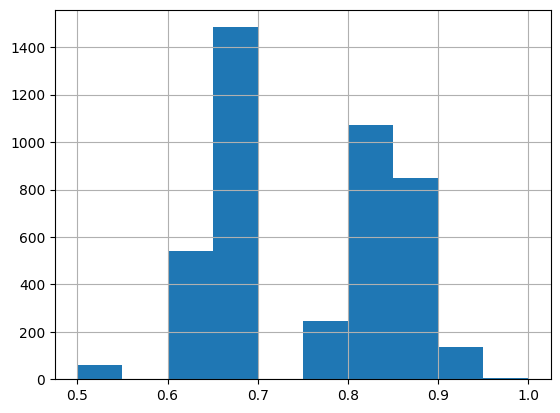

In [25]:
df.how_realistic.hist()

In [26]:
df[df.how_realistic > 0.7]

,id,question,answer,message_ids,how_realistic,inbox_address,query_date
0,0,Were there any variances detected for hour 6 o...,"Yes, variances were detected in both Generatio...",[<17407857.1075840601283.JavaMail.evans@thyme>],0.80,pete.davis@enron.com,2001-03-16
1,1,What changes are happening to the ISDA Master ...,"On July 5, 1999, NationsBank changed its name ...",[<8710990.1075846915948.JavaMail.evans@thyme>],0.85,tana.jones@enron.com,1999-09-07
3,5,When will the new Weekly Report be delivered e...,8am Monday mornings.,[<22065851.1075849817284.JavaMail.evans@thyme>...,0.85,louise.kitchen@enron.com,2001-02-02
4,6,What are the color codes used in curve assessm...,"Green: curve is reasonable, small P&L impact f...",[<12499967.1075846153495.JavaMail.evans@thyme>...,0.80,steven.kean@enron.com,2000-05-10
5,7,What do I need for the vendor raffle gift lett...,You need two letters: one to thank vendors for...,[<4784678.1075841609536.JavaMail.evans@thyme>],0.80,kate.symes@enron.com,2000-10-11
...,...,...,...,...,...,...,...
4384,6122,Is Duke Energy Trading and Marketing an approv...,"No, Duke Energy Trading and Marketing is not a...","[<4293129.1075859913281.JavaMail.evans@thyme>,...",0.95,william.bradford@enron.com,2000-03-13
4385,6123,What was the main reason cited by the EPA for ...,MTBE poses a risk to public health or the envi...,[<22251454.1075844935822.JavaMail.evans@thyme>...,0.75,richard.shapiro@enron.com,2000-04-14
4386,6124,What is the reporting schedule for consolidate...,DPR will be published on normal schedule for 1...,"[<6212416.1075855927855.JavaMail.evans@thyme>,...",0.80,sally.beck@enron.com,2000-01-09
4387,6125,What concerns do we have about PG&E Gen partic...,Concerns about PG&E Gen's access to non-public...,[<22094135.1075842931881.JavaMail.evans@thyme>...,0.80,jeff.dasovich@enron.com,1999-10-10
